# Import Libraries

In [70]:
import os
import sys
import config as cfg
import mysql.connector

import pandas as pd
import numpy as np
import math

# Environment variables
from dotenv import load_dotenv
load_dotenv("mysql.env")

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# Model
from arch import arch_model
from arch.__future__ import reindexing

print('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
print(sys.version)

Machine: Darwin x86_64

3.8.12 | packaged by conda-forge | (default, Sep 16 2021, 01:59:00) 
[Clang 11.1.0 ]


# MySQL connection
Choosing one stock from SQL query to reduce query time.

In [83]:
HOST=os.environ.get("HOST")
PORT=os.environ.get("PORT")
USER=os.environ.get("USER")
PASSWORD=os.environ.get("PASSWORD")

try: 
    conn = mysql.connector.connect(
        host=HOST,
        port=PORT,
        user=USER,
        password=PASSWORD,
        database="GlobalMarketData"
    )
    query = "SELECT Date, Close, Open, High, Low, Volume from histdailyprice3 WHERE Symbol='AAPL';"
    df = pd.read_sql(query, conn)
    conn.close()
except Exception as e:
    mydb.close()
    print(str(e))

# Data

In [16]:
df.head()

,Date,Close,Open,High,Low,Volume
0,1998-01-01,0.1172,0.1172,0.1172,0.1172,0
1,1998-01-02,0.1217,0.1451,0.1205,0.1451,25646800
2,1998-01-05,0.1473,0.1479,0.1356,0.1418,23277200
3,1998-01-06,0.1423,0.1786,0.1317,0.1691,64766000
4,1998-01-07,0.1680,0.1697,0.1546,0.1563,37200800


## Calculate Daily Returns

In [17]:
df['Return'] = 100 * (df['Close'].pct_change())

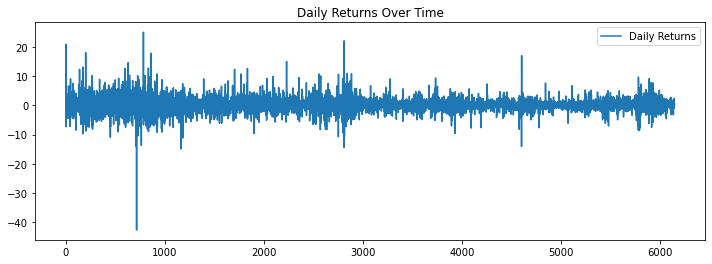

In [20]:
df.dropna(inplace=True)

fig = plt.figure()
fig.set_figwidth(12)
plt.plot(df['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')
plt.show()

## Calculate daily, monthly, and annual volatitily

In [43]:
daily_volatility = df['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  2.66%
Monthly volatility:  12.20%
Annual volatility:  42.27%


# ACF and PACF

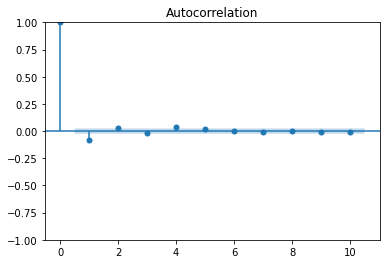

In [38]:
# create acf plot
plot_acf(df["Return"], lags=10)
plt.show()

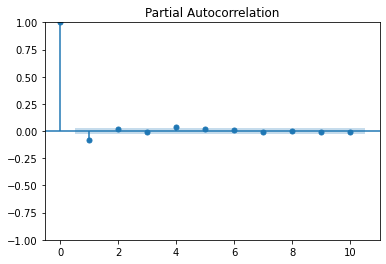

In [48]:
# create pacf plot
plot_pacf(df["Return"], lags=10, method='ywm')
plt.show()

In [77]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5, method="ywm")
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

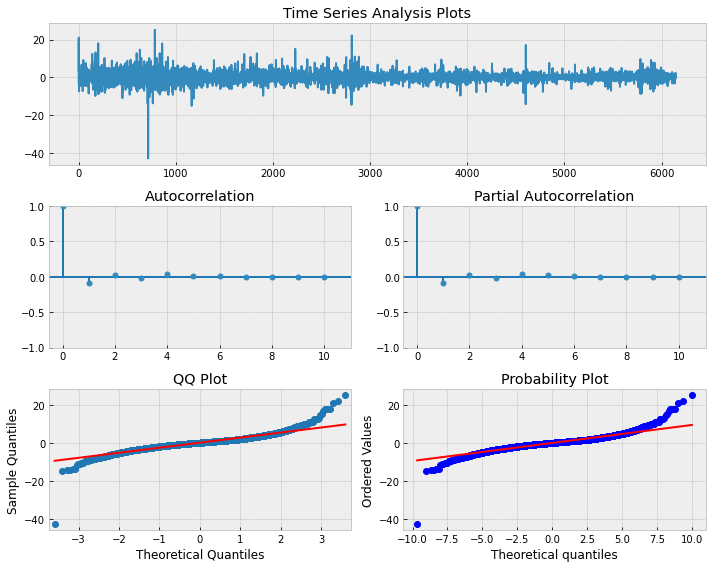

In [79]:
tsplot(df["Return"], lags=10)

# Train Test Split

In [52]:
# split into train/test
n_test = int(0.7 * len(df))
train, test = df[:-n_test], df[-n_test:]

## Predict Stock Volatilty using GARCH model
Generalized Auto Regressive Conditional Heteroskedasticity

In [57]:
garch_model = arch_model(df['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu          0.205319
omega       0.085137
alpha[1]    0.082471
beta[1]     0.907835
Name: params, dtype: float64


           h.1       h.2       h.3      h.4       h.5
6146  2.086417  2.151329  2.215611  2.27927  2.342312


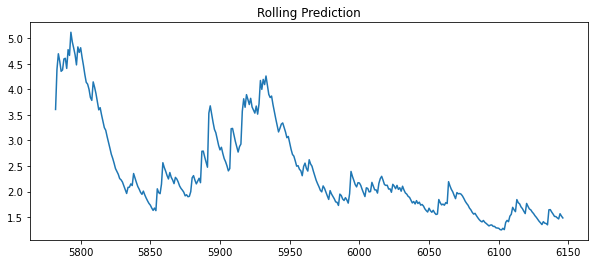

In [60]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = df['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df['Return'].index[-365:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

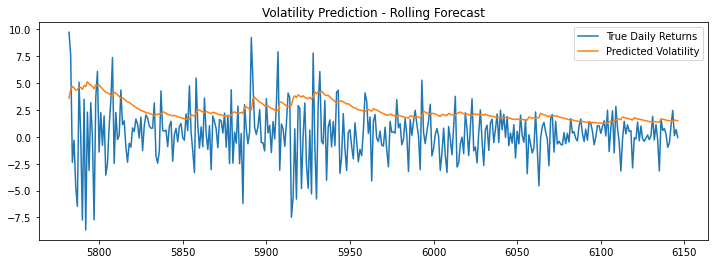

In [61]:
plt.figure(figsize=(12,4))
plt.plot(df['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()